In [43]:
import numpy as np
import pandas as pd
import scipy.io as sio
import gsw
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({
    "figure.facecolor":  "white",  
    "savefig.facecolor": "white",  
})
import scipy.signal as signal

import src.helper as helper
from src.mooring import Mooring
from src.location import Location
from src.ctd_cast import CTDCast

In [44]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# Get each mooring location

In [45]:
# load all 7 moorings as dataframes
list_of_moorings = helper.IO.load_pickle(name="../../data/mooring/list_of_moorings.pkl")

In [46]:
mooring_locations = [mooring.location for mooring in list_of_moorings]
mooring_locations

[Location(lat=-63.4032, lon=-52.287),
 Location(lat=-63.5145, lon=-51.6357),
 Location(lat=-63.656, lon=-50.8113),
 Location(lat=-63.7783, lon=-50.0897),
 Location(lat=-63.917, lon=-49.2682),
 Location(lat=-64.0665, lon=-48.3805),
 Location(lat=-64.2157, lon=-47.4903)]

# Load buoyancy frequency $N$


### Previous N calculations
63.41°S, 52.27°W: 1.25e-03  
63.48°S, 51.61°W: 1.06e-03  
63.67°S, 50.75°W: 1.28e-03  
63.73°S, 50.35°W: 1.32e-03  
63.88°S, 49.16°W: 1.39e-03  
64.08°S, 48.36°W: 1.36e-03  
64.28°S, 47.47°W: 4.40e-04  


* from *CTD/Even better N calculation*
* All values are in units of (rad/s)

In [47]:
N_table = pd.read_pickle("./method_data/N_values.pkl") 
N_table

,mab,"(-63.40,-52.29)","(-63.51,-51.64)","(-63.66,-50.81)","(-63.78,-50.09)","(-63.92,-49.27)","(-64.07,-48.38)","(-64.22,-47.49)"
0,0,0.000295,0.000136,0.000180,0.000234,0.000250,0.001107,0.001026
1,1,0.000314,0.000142,0.000181,0.000238,0.000271,0.001147,0.001098
2,2,0.000315,0.000145,0.000225,0.000242,0.000301,0.001182,0.001154
3,3,0.000307,0.000159,0.000223,0.000246,0.000325,0.001212,0.001183
4,4,0.000303,0.000171,0.000249,0.000250,0.000368,0.001237,0.001206
...,...,...,...,...,...,...,...,...
595,595,0.001432,0.000846,0.000719,0.000679,0.000540,0.000486,0.000455
596,596,0.001431,0.000852,0.000721,0.000677,0.000541,0.000483,0.000457
597,597,0.001427,0.000858,0.000716,0.000675,0.000541,0.000498,0.000458
598,598,0.001422,0.000857,0.000711,0.000674,0.000539,0.000497,0.000458


In [48]:
N_table.iloc[:,2]

0      0.000136
1      0.000142
2      0.000145
3      0.000159
4      0.000171
         ...   
595    0.000846
596    0.000852
597    0.000858
598    0.000857
599    0.000858
Name: (-63.51,-51.64), Length: 600, dtype: float64

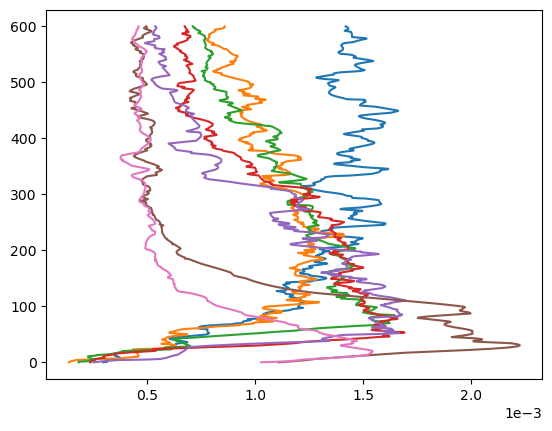

In [49]:
for i,_ in enumerate(N_table.columns):
    if i == 0: continue
    plt.plot(N_table.iloc[:,i],N_table.index)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

In [50]:
N_error_table = pd.read_pickle("./method_data/N_std.pkl")  
N_error_table

,mab,"(-63.40,-52.29)","(-63.51,-51.64)","(-63.66,-50.81)","(-63.78,-50.09)","(-63.92,-49.27)","(-64.07,-48.38)","(-64.22,-47.49)"
0,0,0.000176,0.000434,0.000199,0.000222,0.000294,0.000431,0.000192
1,1,0.000173,0.000419,0.000195,0.000194,0.000280,0.000451,0.000207
2,2,0.000177,0.000463,0.000188,0.000159,0.000307,0.000441,0.000207
3,3,0.000186,0.000520,0.000209,0.000213,0.000286,0.000425,0.000185
4,4,0.000197,0.000397,0.000217,0.000187,0.000275,0.000404,0.000204
...,...,...,...,...,...,...,...,...
595,595,0.000365,0.000152,0.000053,0.000123,0.000092,0.000049,0.000027
596,596,0.000354,0.000162,0.000050,0.000131,0.000091,0.000054,0.000029
597,597,0.000340,0.000140,0.000048,0.000137,0.000092,0.000049,0.000033
598,598,0.000334,0.000125,0.000058,0.000133,0.000093,0.000049,0.000040


# Load energy levels

created by the script *calculate_available_energy_levels.py*

In [51]:
data = np.load("./method_data/results_available_energy.npz", allow_pickle = True) 
energy_levels = pd.DataFrame(data = {
    "lon":data["lon"], 
    "lat":data["lat"], 
    "rounded_depth": data["depth"],
    "rounded_mab": data["mab"],
    "barotropic":data["barotropic"],
    "continuum":data["continuum"],
    "available":data["available"],

})

In [52]:
energy_levels["rounded_depth"] = energy_levels["rounded_depth"].astype("int")

In [53]:
#energy_levels["energy_level"] = energy_levels["IW"] + energy_levels["barotropic"] + energy_levels["baroclinic"].fillna(0)

In [54]:
energy_levels

,lon,lat,rounded_depth,rounded_mab,barotropic,continuum,available
0,-52.2870,-63.4032,299,343,0.000807,0.000353,0.000353
1,-52.2870,-63.4032,505,137,0.000807,0.000559,0.000741
2,-52.2870,-63.4032,614,28,0.000807,0.000645,0.000850
3,-51.6357,-63.5145,1318,338,0.000423,0.000365,0.000476
4,-51.6357,-63.5145,1513,143,0.000423,0.000544,0.000592
5,-51.6357,-63.5145,1625,31,0.000423,0.000376,0.000376
6,-50.8113,-63.6560,2143,350,0.000237,0.000313,0.000454
7,-50.8113,-63.6560,2350,143,0.000237,0.000421,0.000563
8,-50.0897,-63.7783,2400,357,0.000190,0.000498,0.000507
9,-50.0897,-63.7783,2615,142,0.000190,0.000414,0.000438


energy_levels.plot(x = "lon", y = ["barotropic","baroclinic","IW"], marker = ".", ls = "None", ms = 30, figsize=(15, 8))
#plt.plot(energy_levels["lon"],energy_levels["energy_level"],".")

energy_levels.plot(x = "lon", y = ["barotropic","IW"], marker = ".", ls = "None", ms = 30, figsize=(15, 8))

In [55]:
energy_levels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   lon            17 non-null     float64
 1   lat            17 non-null     float64
 2   rounded_depth  17 non-null     int64  
 3   rounded_mab    17 non-null     int64  
 4   barotropic     17 non-null     float64
 5   continuum      17 non-null     float64
 6   available      17 non-null     float64
dtypes: float64(5), int64(2)
memory usage: 1.1 KB


# Add Meters Above Bottom dimension

data = np.load("data/max_depth_dict.npz", allow_pickle = True)
max_depth_dict = data["max_depth_dict"].item()

for index, row in energy_levels.iterrows():
    # get instrument depth in units of meter above the sea floor
    mab_of_measurement = int(max_depth_dict[mooring.location.lon]) - int(shallowest_depth) 
    #print("Shallow Test:",mab_of_measurement)

data = np.load("/home/ole/Desktop/Mooring_Analysis/notebooks/poster_temperature_data.npz")
mab_df = pd.DataFrame(data = {"lon": data["uv_lon"], "rounded_depths": data["uv_depth"], "mab": data["uv_mab"]})
mab_df["rounded_depths"] = mab_df["rounded_depths"].round(0).astype(int)
mab_df["mab"] = mab_df["mab"].round(0).astype(int)
mab_df

energy_levels = pd.merge(energy_levels, mab_df)
energy_levels

"""
energy_levels["max depth"] = np.nan
for value in set(energy_levels["lon"]):
    
    max_depth = energy_levels[energy_levels['lon']==value]['rounded_depths'].max() +5
    energy_levels.loc[energy_levels['lon'] == value, 'max depth'] = max_depth  
    print(value,max_depth)
    #energy_levels.query('lon==value')#['mab'] #= energy_levels["rounded_depths"]  df.query('lon==-52.2870')
"""    

In [56]:
#get N values and Errors at the geographic locations and depths of the energy levels

N_array = []
N_error_array = []

for index, row in energy_levels.iterrows():
    column_name = f"({row['lat']:.2f},{row['lon']:.2f})"
    #print(column_name)
    try:
        N_value = N_table.loc[N_table['mab'] == row["rounded_mab"], column_name].item()
        N_error = N_error_table.loc[N_error_table['mab'] == row["rounded_mab"], column_name].item()
    except ValueError:
        N_value = np.nan
        N_error = np.nan
    #print(N_error)
    N_array.append(N_value)
    N_error_array.append(N_error) 
    
energy_levels["N"] = N_array
energy_levels["N Error"] = N_error_array
energy_levels

,lon,lat,rounded_depth,rounded_mab,barotropic,continuum,available,N,N Error
0,-52.2870,-63.4032,299,343,0.000807,0.000353,0.000353,0.001586,0.000466
1,-52.2870,-63.4032,505,137,0.000807,0.000559,0.000741,0.001135,0.000268
2,-52.2870,-63.4032,614,28,0.000807,0.000645,0.000850,0.000614,0.000283
3,-51.6357,-63.5145,1318,338,0.000423,0.000365,0.000476,0.001157,0.000225
4,-51.6357,-63.5145,1513,143,0.000423,0.000544,0.000592,0.001206,0.000233
5,-51.6357,-63.5145,1625,31,0.000423,0.000376,0.000376,0.000628,0.000297
6,-50.8113,-63.6560,2143,350,0.000237,0.000313,0.000454,0.001097,0.000061
7,-50.8113,-63.6560,2350,143,0.000237,0.000421,0.000563,0.001377,0.000211
8,-50.0897,-63.7783,2400,357,0.000190,0.000498,0.000507,0.000972,0.000140
9,-50.0897,-63.7783,2615,142,0.000190,0.000414,0.000438,0.001407,0.000204


Text(0.5, 1.0, 'N in cpd')

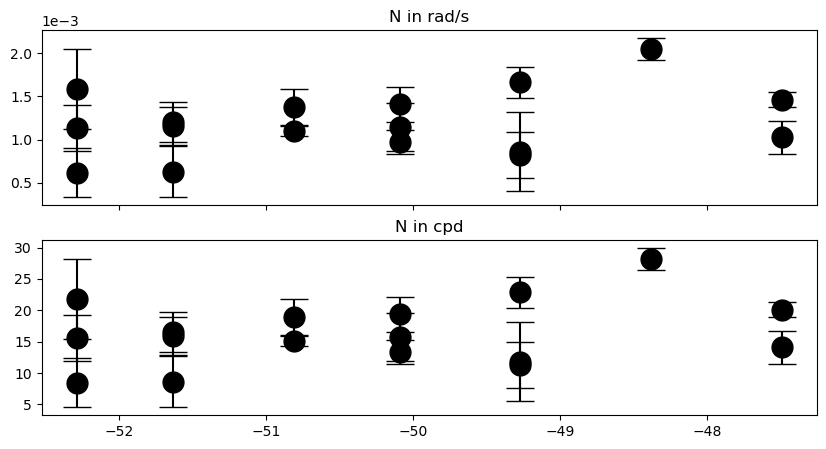

In [57]:
f,a = plt.subplots(nrows = 2, sharex = True, figsize = (10,5))
a[0].errorbar(energy_levels["lon"], energy_levels["N"], yerr = energy_levels["N Error"], capsize = 10, marker = ".", color = "k", ls = "None", ms = 30 )
a[0].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
a[1].errorbar(energy_levels["lon"], energy_levels["N"]/(2*np.pi)*86400, yerr = energy_levels["N Error"]/(2*np.pi)*86400, capsize = 10, marker = ".", color = "k", ls = "None", ms = 30 )
#a[1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
a[0].set_title("N in rad/s")
a[1].set_title("N in cpd")

# Calculate Diffusivities

In [58]:
#get coriolis frequency at the geographic location of every mooring
energy_levels["coriolis frequency"] = energy_levels.apply(lambda row: helper.Constants.get_coriolis_frequency(row["lat"], unit = "rad/s"), axis=1)

# set negative energies to be NaN
#energy_levels.loc[energy_levels["baroclinic"] < 0, "baroclinic"] = np.NaN
energy_levels

,lon,lat,rounded_depth,rounded_mab,barotropic,continuum,available,N,N Error,coriolis frequency
0,-52.2870,-63.4032,299,343,0.000807,0.000353,0.000353,0.001586,0.000466,-0.000130
1,-52.2870,-63.4032,505,137,0.000807,0.000559,0.000741,0.001135,0.000268,-0.000130
2,-52.2870,-63.4032,614,28,0.000807,0.000645,0.000850,0.000614,0.000283,-0.000130
3,-51.6357,-63.5145,1318,338,0.000423,0.000365,0.000476,0.001157,0.000225,-0.000131
4,-51.6357,-63.5145,1513,143,0.000423,0.000544,0.000592,0.001206,0.000233,-0.000131
5,-51.6357,-63.5145,1625,31,0.000423,0.000376,0.000376,0.000628,0.000297,-0.000131
6,-50.8113,-63.6560,2143,350,0.000237,0.000313,0.000454,0.001097,0.000061,-0.000131
7,-50.8113,-63.6560,2350,143,0.000237,0.000421,0.000563,0.001377,0.000211,-0.000131
8,-50.0897,-63.7783,2400,357,0.000190,0.000498,0.000507,0.000972,0.000140,-0.000131
9,-50.0897,-63.7783,2615,142,0.000190,0.000414,0.000438,0.001407,0.000204,-0.000131


# use $K_\rho \approx \frac{\Gamma}{1+\Gamma} \mu_0 f_e \frac{(m_\star/N)^2E^2}{N^2}$ with 
   - $\Gamma = 0.2$
   - $\mu_0 = \frac{2}{3} $
   - $m_\star = 0.01\,$m$^{-1}$
   - $f_e = |f| \mathrm{arccosh}(\frac{N}{|f|}) $
   - $E^2 = \text{Wave continuum energy} $
   - $N = \text{bouyoancy frequency}$

def get_diapycnal_diffusivity(coriolis_frequency, buoyancy_frequency, energy_level):
    """
    eq. 18 from Olbers & Eden, 2013
    """
    MIXING_EFFICIENCY = 0.2
    MU_0 = 1 / 3 #value recommeded by Pollmann et al., 2017
    m_star = 0.01
    effective_coriolis_frequency = (
        np.abs(coriolis_frequency) * 
        np.arccosh(buoyancy_frequency / np.abs(coriolis_frequency))
    )
        
    diapycnal_diffusivity = (
        MIXING_EFFICIENCY / (1 + MIXING_EFFICIENCY)
        * MU_0
        * effective_coriolis_frequency
        * (m_star / buoyancy_frequency) ** 2
        * energy_level**2
        / buoyancy_frequency**2
    )

    return diapycnal_diffusivity

def get_error_of_diapycnal_diffusivity(coriolis_frequency, buoyancy_frequency, error_buoyancy_frequency, energy_level, error_energy_level):
    """
    eq. 18 from Olbers & Eden, 2013
    """
    MIXING_EFFICIENCY = 0.2
    MU_0 = 1 / 3 #value recommeded by Pollmann et al 2017
    m_star = 0.01

    arccosh_derivative = (
        1/(
            np.sqrt(buoyancy_frequency / np.abs(coriolis_frequency) - 1)
            *np.sqrt(buoyancy_frequency / np.abs(coriolis_frequency) + 1)
            )
        * m_star** 2
        * energy_level**2
        / buoyancy_frequency**4
        )
        
    exponent_derivative = (
        np.arccosh(buoyancy_frequency / np.abs(coriolis_frequency))
        * -4 * m_star** 2
        * energy_level**2
        / buoyancy_frequency**5
    )
    
    error_due_to_N = (
        MIXING_EFFICIENCY / (1 + MIXING_EFFICIENCY)
        * MU_0 * np.abs(coriolis_frequency)
        * (arccosh_derivative +  exponent_derivative)
        * error_buoyancy_frequency
    )
    
    effective_coriolis_frequency = (
        np.abs(coriolis_frequency) * 
        np.arccosh(buoyancy_frequency / np.abs(coriolis_frequency))
    )
        
    error_due_to_E = (
        MIXING_EFFICIENCY / (1 + MIXING_EFFICIENCY)
        * MU_0
        * effective_coriolis_frequency
        * 2 * m_star** 2
        * energy_level
        / buoyancy_frequency**4
        * error_energy_level
    )

    assert error_due_to_E == 0 or np.isnan(error_due_to_E)
    
    total_error = np.sqrt(error_due_to_N**2 + error_due_to_E**2)
    
    return total_error

energy_levels["K_rho_IW"] = energy_levels.apply(
    lambda row: get_diapycnal_diffusivity(
        coriolis_frequency = row['coriolis frequency'], 
        buoyancy_frequency = row['N'], 
        energy_level = row['IW'])
    , axis=1)

energy_levels["K_rho_IW_error"] = energy_levels.apply(
    lambda row: get_error_of_diapycnal_diffusivity(
        coriolis_frequency = row['coriolis frequency'], 
        buoyancy_frequency = row['N'], 
        error_buoyancy_frequency = row['N Error'],
        energy_level = row['IW'],
        error_energy_level = 0)
    , axis=1)

energy_levels["K_rho"] = energy_levels.apply(
    lambda row: get_diapycnal_diffusivity(
        coriolis_frequency = row['coriolis frequency'], 
        buoyancy_frequency = row['N'], 
        energy_level = row['IW'] + row['baroclinic'])
    , axis=1)

energy_levels["K_rho_error"] = energy_levels.apply(
    lambda row: get_error_of_diapycnal_diffusivity(
        coriolis_frequency = row['coriolis frequency'], 
        buoyancy_frequency = row['N'], 
        error_buoyancy_frequency = row['N Error'],
        energy_level = row['IW'] + row['baroclinic'],
        error_energy_level = 0)
    , axis=1)

#energy_levels["K_rho magnitude"] = np.floor(np.log10(energy_levels["K_rho"]))
#df.style.format(formatter={('K_rho', 'energy_level', 'coriolis frequency', 'mean_N'): lambda x: "$ {:,.1e}.format"})
#pd.set_option('display.float_format', '{:.3e}'.format)
energy_levels

In [59]:
def get_dissipation_rate(coriolis_frequency, buoyancy_frequency, energy_level):
    """
    eq. 18 from Olbers & Eden, 2013
    """
    MIXING_EFFICIENCY = 0.2
    MU_0 = 1 / 3 #value recommeded by Pollmann et al., 2017
    m_star = 0.01
    effective_coriolis_frequency = (
        np.abs(coriolis_frequency) * 
        np.arccosh(buoyancy_frequency / np.abs(coriolis_frequency))
    )
        
    dissipation_rate = (
        1 / (1 + MIXING_EFFICIENCY)
        * MU_0
        * effective_coriolis_frequency
        * (m_star) ** 2
        * energy_level**2
        / buoyancy_frequency**2
    )

    return dissipation_rate

In [60]:
def get_error_of_dissipation_rate(coriolis_frequency, buoyancy_frequency, error_buoyancy_frequency, energy_level, error_energy_level):
    """
    eq. 18 from Olbers & Eden, 2013
    """
    MIXING_EFFICIENCY = 0.2
    MU_0 = 1 / 3 #value recommeded by Pollmann et al 2017
    m_star = 0.01

    arccosh_N_derivative = (
        1/(
            np.sqrt(buoyancy_frequency / np.abs(coriolis_frequency) - 1)
            *np.sqrt(buoyancy_frequency / np.abs(coriolis_frequency) + 1)
            )
        * m_star** 2
        * energy_level**2
        / buoyancy_frequency**2
        )
        
    exponent_N_derivative = (
        np.arccosh(buoyancy_frequency / np.abs(coriolis_frequency))
        * -2 * m_star** 2
        * energy_level**2
        / buoyancy_frequency**3
    )
    
    error_due_to_N = (
        1/ (1 + MIXING_EFFICIENCY)
        * MU_0 * np.abs(coriolis_frequency)
        * (arccosh_N_derivative +  exponent_N_derivative)
        * error_buoyancy_frequency
    )
    
    effective_coriolis_frequency = (
        np.abs(coriolis_frequency) * 
        np.arccosh(buoyancy_frequency / np.abs(coriolis_frequency))
    )
        
    error_due_to_E = (
        1 / (1 + MIXING_EFFICIENCY)
        * MU_0
        * effective_coriolis_frequency
        * 2 * m_star** 2
        * energy_level
        / (buoyancy_frequency**2)
        * error_energy_level
    )

    assert error_due_to_E == 0 or np.isnan(error_due_to_E)
    
    dissipation_total_error = np.sqrt(error_due_to_N**2 + error_due_to_E**2)
    
    return dissipation_total_error

# Stopped Here!

* Calculate dissipation rates
* come up with Delta E
* new figures
* new comparison figures

In [61]:
energy_levels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   lon                 17 non-null     float64
 1   lat                 17 non-null     float64
 2   rounded_depth       17 non-null     int64  
 3   rounded_mab         17 non-null     int64  
 4   barotropic          17 non-null     float64
 5   continuum           17 non-null     float64
 6   available           17 non-null     float64
 7   N                   17 non-null     float64
 8   N Error             17 non-null     float64
 9   coriolis frequency  17 non-null     float64
dtypes: float64(8), int64(2)
memory usage: 1.5 KB


In [62]:
ls

 available_energy_levels.log            compare_barotropic_calculations.py
'average N calculation.ipynb'          'local dissipation rates.ipynb'
 calculate_available_energy_levels.py   method_data/
 _calculate_energy_levels.py            plot_energy_levels.py
 CATS_quality_test.py                  'prepare CATS model data.ipynb'
 _compare_barotropic_calculations.py


In [63]:
energy_levels["eps_IGW"] = energy_levels.apply(
    lambda row: get_dissipation_rate(
        coriolis_frequency = row['coriolis frequency'], 
        buoyancy_frequency = row['N'], 
        energy_level = row['available'])
    , axis=1)

energy_levels["eps_IGW_error"] = energy_levels.apply(
    lambda row: get_error_of_dissipation_rate(
        coriolis_frequency = row['coriolis frequency'], 
        buoyancy_frequency = row['N'], 
        error_buoyancy_frequency = row['N Error'],
        energy_level = row['available'],
        error_energy_level = 0)
    , axis=1)



"""
energy_levels["eps"] = energy_levels.apply(
    lambda row: get_dissipation_rate(
        coriolis_frequency = row['coriolis frequency'], 
        buoyancy_frequency = row['N'], 
        energy_level = row['IW'] + row['baroclinic'])
    , axis=1)

energy_levels["eps_error"] = energy_levels.apply(
    lambda row: get_error_of_dissipation_rate(
        coriolis_frequency = row['coriolis frequency'], 
        buoyancy_frequency = row['N'], 
        error_buoyancy_frequency = row['N Error'],
        energy_level = row['IW'] + row['baroclinic'],
        error_energy_level = 0)
    , axis=1)
""";  

In [64]:
energy_levels.to_csv('./method_data/eps_IGW_IDEMIX_results.csv')
energy_levels

,lon,lat,rounded_depth,rounded_mab,barotropic,continuum,available,N,N Error,coriolis frequency,eps_IGW,eps_IGW_error
0,-52.2870,-63.4032,299,343,0.000807,0.000353,0.000353,0.001586,0.000466,-0.000130,5.737885e-10,3.375302e-10
1,-52.2870,-63.4032,505,137,0.000807,0.000559,0.000741,0.001135,0.000268,-0.000130,4.402297e-09,2.082132e-09
2,-52.2870,-63.4032,614,28,0.000807,0.000645,0.000850,0.000614,0.000283,-0.000130,1.548914e-08,1.428215e-08
3,-51.6357,-63.5145,1318,338,0.000423,0.000365,0.000476,0.001157,0.000225,-0.000131,1.764363e-09,6.852270e-10
4,-51.6357,-63.5145,1513,143,0.000423,0.000544,0.000592,0.001206,0.000233,-0.000131,2.549531e-09,9.862588e-10
5,-51.6357,-63.5145,1625,31,0.000423,0.000376,0.000376,0.000628,0.000297,-0.000131,2.919587e-09,2.758179e-09
6,-50.8113,-63.6560,2143,350,0.000237,0.000313,0.000454,0.001097,0.000061,-0.000131,1.753330e-09,1.936854e-10
7,-50.8113,-63.6560,2350,143,0.000237,0.000421,0.000563,0.001377,0.000211,-0.000131,1.846597e-09,5.658936e-10
8,-50.0897,-63.7783,2400,357,0.000190,0.000498,0.000507,0.000972,0.000140,-0.000131,2.659811e-09,7.661273e-10
9,-50.0897,-63.7783,2615,142,0.000190,0.000414,0.000438,0.001407,0.000204,-0.000131,1.082754e-09,3.146275e-10


plt.plot(energy_levels["lat"],energy_levels["coriolis frequency"])

In [65]:
#pd.reset_option('display.float_format')

energy_levels.plot(x = "lon", y = "N", marker = ".", color = "k", ls = "None", ms = 30, figsize=(10, 3)).legend(loc='upper right', facecolor = "lightgray")
energy_levels.plot(x = "lon", y = ["K_rho","K_rho_IW"], marker = ".", ls = "None", logy = True, ms = 30, figsize=(10, 6)).legend(loc='best', facecolor = "lightgray")

f,a = plt.subplots(3, sharex = True, height_ratios = [1,1,2])#, figsize = (16,6))
#f.set_size_inches(8,4)
a[0].semilogy(energy_levels["lon"], energy_levels["N"], marker = ".", color = "k", ls = "None", ms = 15, nonpositive = 'clip')
a[0].errorbar(energy_levels["lon"], energy_levels["N"], yerr = energy_levels["N Error"], capsize = 10, fmt = "None", color = "k")

a[1].semilogy(energy_levels["lon"], energy_levels["IW"] + energy_levels["baroclinic"], marker = ".", c = "tab:blue", ls = "None", ms = 15, label = "all IW, including baroclinic tides")
#a[1].errorbar(energy_levels["lon"], energy_levels["IW"], yerr = energy_levels["N Error"], capsize = 10, fmt = "None", color = "tab:blue")

a[1].semilogy(energy_levels["lon"], energy_levels["IW"], marker = ".", ls = "None", c = "k", markeredgewidth=1.5, markerfacecolor = "none", ms = 30, label = "only IW continuum")
#a[1].errorbar(energy_levels["lon"], energy_levels["IW"], yerr = energy_levels["N Error"], capsize = 10, fmt = "None", color = "k")

a[2].semilogy(energy_levels["lon"], energy_levels["K_rho"], marker = ".", c = "tab:blue", ls = "None", ms = 15, label = "all IW, including tides")
a[2].errorbar(energy_levels["lon"], energy_levels["K_rho"], yerr = energy_levels["K_rho_error"], capsize = 10, fmt = "None", color = "tab:blue")

a[2].semilogy(energy_levels["lon"], energy_levels["K_rho_IW"], marker = ".", ls = "None", c = "k", markeredgewidth=1.5, markerfacecolor = "none", ms = 30, label = "only IW continuum")
a[2].errorbar(energy_levels["lon"], energy_levels["K_rho_IW"], yerr = energy_levels["K_rho_IW_error"], capsize = 10, fmt = "None", color = "k")

a[0].set_ylabel(r"$N$ / (rad s$^{-1}$)")
a[1].set_ylabel(r"$E$ / (m$^2$ s$^{-2}$)")
a[2].set_ylabel(r"$K_\rho$ / (m²s$^{-1}$)")

a[0].set_ylim(6e-4,8e-3)
a[1].set_ylim(1e-4,3e-2)
a[2].set_ylim(1e-6,1)

a[0].set_title(r"Buoyancy frequency $N$")
a[1].set_title(r"Energy level $E$")
a[2].set_title(r"Diapycnal diffusivity $K_\rho$")
import matplotlib
locmaj = matplotlib.ticker.LogLocator(base=10,numticks=6) 
a[2].yaxis.set_major_locator(locmaj)
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=12)
a[2].yaxis.set_minor_locator(locmin)
a[2].yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
a[2].set_xlabel("Longitude (°)")

#a[1].legend(loc = "best", framealpha = 0.6, facecolor = "lightgray")
a[2].legend(loc = "best", framealpha = 0.6, facecolor = "lightgray")
import os
path = os.getcwd()
#help.Plot.path_as_footnote(fig = f, path = path)
f.tight_layout()
help.IO.save_as_pickle((f,a), name= "./data/K_rho_fig")
f.savefig("./figures/Krho_calculation", dpi = 300)

In [66]:
#from IPython.display import Image, display;   
#display(Image(filename='./Krho_calculation_new.png', width = 1000))

from IPython.display import Image, display;   
display(Image(filename='./figures/Krho_calculation.png', width = 1000))

# Now with shifted data points

In [67]:
nr_of_points = 3
xstep = 0.2
a = np.arange(0,nr_of_points*xstep, xstep) 
if nr_of_points%2 != 0 and len(a)!= 1:
    a = a[:-1]
a = a - np.median(a)
print(a)

[-0.2  0.   0.2]


In [ ]:
#find out how many points per location will be drawn
groups = energy_levels.groupby("lon")
f,a = plt.subplots(3, sharex = True, height_ratios = [1,1,2], figsize = (8,5))
for lon in set(energy_levels["lon"]):
    print(lon)
    group = groups.get_group(lon)
    group = group.sort_values("mab")
    print(group["mab"])
    nr_of_points = len(group.index)

    #to declutter the figure, points are shifted centered around the original x value. 
    # magintude of the shift in units of the x coordinate
    xstep = 0.1
    xshift = np.arange(0,nr_of_points*xstep, xstep) 
    #disticntion between 1 point (no shifts), odd and even points
    if nr_of_points%2 != 0 and len(xshift)!= 1:
        xshift = xshift[:-1]
    #centering    
    xshift = xshift - np.median(xshift)
    
    print(xshift)
    #print(group)
    a[0].errorbar(group["lon"] + xshift, group["N"], yerr = group["N Error"], capsize = 10, fmt = "None", color = "gray")
    a[0].semilogy(group["lon"] + xshift, group["N"], marker = ".", color = "k", ls = "None", ms = 15, nonpositive = 'clip')


    #a[1].errorbar(group["lon"], group["IW"], yerr = group["N Error"], capsize = 10, fmt = "None", color = "tab:blue")
    #a[1].errorbar(group["lon"], group["IW"], yerr = group["N Error"], capsize = 10, fmt = "None", color = "k")
    
    if not group["baroclinic"].isnull().values.all():
        a[1].semilogy(group["lon"] + xshift, group["IW"] + group["baroclinic"], marker = ".", c = "tab:blue", ls = "None", ms = 15, label = "all IW, including baroclinic tides")

        a[2].errorbar(group["lon"] + xshift, group["K_rho"], yerr = group["K_rho_error"], capsize = 10, fmt = "None", color = "xkcd:sky blue")
        a[2].semilogy(group["lon"] + xshift, group["K_rho"], marker = ".", c = "tab:blue", ls = "None", ms = 15, label = "all IW, including tides")


    a[1].semilogy(group["lon"] + xshift, group["IW"], marker = ".", ls = "None", c = "k", markeredgewidth=1.5, markerfacecolor = "none", ms = 20, label = "only IW continuum")
    
    a[2].errorbar(group["lon"] + xshift, group["K_rho_IW"], yerr = group["K_rho_IW_error"], capsize = 10, fmt = "None", color = "gray")
    a[2].semilogy(group["lon"] + xshift, group["K_rho_IW"], marker = ".", ls = "None", c = "k", markeredgewidth=1.5, markerfacecolor = "none", ms = 20, label = "only IW continuum")

    
a[0].set_ylabel(r"$N$ / (rad s$^{-1}$)")
a[1].set_ylabel(r"$E$ / (m$^2$ s$^{-2}$)")
a[2].set_ylabel(r"$K_\rho$ / (m²s$^{-1}$)")

a[0].set_ylim(0.3e-3,3e-3)
rad_per_s_to_CPD = 86400 / (2*np.pi)
ax_CPD = a[0].twinx()
mn, mx = a[0].get_ylim()
#ax_CPD.set_ylim(mn*rad_per_s_to_CPD, mx*rad_per_s_to_CPD)
#ax_CPD.set_ylabel('N / cpd')
#ax_CPD.ticklabel_format(style='sci', axis='y', scilimits=(0,0))


a[1].set_ylim(1e-4,1e-2)
a[2].set_ylim(1e-6,1)

a[0].set_title(r"Buoyancy frequency $N$")
a[1].set_title(r"Energy level $E$")
a[2].set_title(r"Diapycnal diffusivity $K_\rho$")
import matplotlib
locmaj = matplotlib.ticker.LogLocator(base=10,numticks=6) 
a[2].yaxis.set_major_locator(locmaj)
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=12)
a[2].yaxis.set_minor_locator(locmin)
a[2].yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
a[2].set_xlabel("Longitude (°)")

#a[1].legend(loc = "best", framealpha = 0.6, facecolor = "lightgray")
#a[2].legend(loc = "best", framealpha = 0.6, facecolor = "lightgray")
import os
path = os.getcwd()
help.Plot.path_as_footnote(fig = f, path = path)
f.tight_layout()
f.subplots_adjust(hspace=0.3) 
help.IO.save_as_pickle((f,a), name= "./data/K_rho_fig")
f.savefig("./figures/Krho_calculation", dpi = 300)

from IPython.display import Image, display;   
display(Image(filename='./figures/Krho_calculation.png', width = 1000))   
#display(Image(filename='./Krho_fig.svg', width = 1000))

#find out how many points per location will be drawn
groups = energy_levels.groupby("lon")
f,a = plt.subplots(nrows = 4, sharex = True, height_ratios = [1,1,2,2], figsize = (8,8))
for lon in set(energy_levels["lon"]):
    print(lon)
    group = groups.get_group(lon)
    group = group.sort_values("mab")
    nr_of_points = len(group.index)

    #to declutter the figure, points are shifted centered around the original x value. 
    # magnitude of the shift in units of the x coordinate
    xstep = 0.1
    xshift = np.arange(0,nr_of_points*xstep, xstep) 
    #distinction between 1 point (no shifts), odd and even points
    if nr_of_points%2 != 0 and len(xshift)!= 1:
        xshift = xshift[:-1]
    #centering    
    xshift = xshift - np.median(xshift)
    
    #print(xshift)
    #print(group)
    a[0].errorbar(group["lon"] + xshift, group["N"], yerr = group["N Error"], capsize = 10, fmt = "None", color = "gray")
    a[0].semilogy(group["lon"] + xshift, group["N"], marker = ".", color = "k", ls = "None", ms = 15, nonpositive = 'clip')


    #a[1].errorbar(group["lon"], group["IW"], yerr = group["N Error"], capsize = 10, fmt = "None", color = "tab:blue")
    #a[1].errorbar(group["lon"], group["IW"], yerr = group["N Error"], capsize = 10, fmt = "None", color = "k")
    
    # plot baroclinic values if they exist
    if not group["baroclinic"].isnull().values.all():
        a[1].semilogy(group["lon"] + xshift, group["IW"] + group["baroclinic"], marker = ".", c = "tab:blue", ls = "None", ms = 15, label = "all IW, including baroclinic tides")

        a[2].errorbar(group["lon"] + xshift, group["K_rho"], yerr = group["K_rho_error"], capsize = 10, fmt = "None", color = "xkcd:sky blue")
        a[2].semilogy(group["lon"] + xshift, group["K_rho"], marker = ".", c = "tab:blue", ls = "None", ms = 15, label = "all IW, including tides")


    a[1].semilogy(group["lon"] + xshift, group["IW"], marker = ".", ls = "None", c = "k", markeredgewidth=1.5, markerfacecolor = "none", ms = 20, label = "only IW continuum")
    
    a[2].errorbar(group["lon"] + xshift, group["K_rho_IW"], yerr = group["K_rho_IW_error"], capsize = 10, fmt = "None", color = "gray")
    a[2].semilogy(group["lon"] + xshift, group["K_rho_IW"], marker = ".", ls = "None", c = "k", markeredgewidth=1.5, markerfacecolor = "none", ms = 20, label = "only IW continuum")

    # label = "all IW, including tides"
    a[3].semilogy(group["lon"] + xshift, group["eps"], marker = ".", c = "tab:blue", ls = "None", ms = 15)
    
    #label = "only IW continuum"
    a[3].semilogy(group["lon"] + xshift, group["eps_IW"], marker = ".", ls = "None", c = "k", markeredgewidth=1.5, markerfacecolor = "none", ms = 20)
    
a[0].set_ylabel(r"$N$ / (rad s$^{-1}$)")
a[1].set_ylabel(r"$E$ / (m$^2$ s$^{-2}$)")
a[2].set_ylabel(r"$K_\rho$ / (m²s$^{-1}$)")

#a[0].set_ylim(6e-4,8e-3)
rad_per_s_to_CPD = 86400 / (2*np.pi)
ax_CPD = a[0].twinx()
mn, mx = a[0].get_ylim()
ax_CPD.set_ylim(mn*rad_per_s_to_CPD, mx*rad_per_s_to_CPD)
ax_CPD.set_ylabel('N / cpd')
#ax_CPD.ticklabel_format(style='sci', axis='x', scilimits=(0,0))


a[1].set_ylim(1e-4,1e-2)
a[2].set_ylim(1e-6,1)
ylims = a[3].get_ylim()
# for the legend
a[3].semilogy(group["lon"] + xshift, 1e10*group["K_rho"]/0.2*group["N"]**2, marker = ".", c = "tab:blue", ls = "None", ms = 15, label = "all IW, including tides")
a[3].semilogy(group["lon"] + xshift, 1e10*group["K_rho_IW"]/0.2*group["N"]**2, marker = ".", ls = "None", c = "k", markeredgewidth=1.5, markerfacecolor = "none", ms = 20, label = "only IW continuum")
a[3].set_ylim(ylims)
    
    
    
a[0].set_title(r"Buoyancy frequency $N$")
a[1].set_title(r"Energy level $E$")
a[2].set_title(r"Diapycnal diffusivity $K_\rho$")
a[3].set_title(r"Dissipation rate $\varepsilon$")
import matplotlib
locmaj = matplotlib.ticker.LogLocator(base=10,numticks=6) 
a[2].yaxis.set_major_locator(locmaj)
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=12)
a[2].yaxis.set_minor_locator(locmin)
a[2].yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
a[3].set_xlabel("Longitude (°)")

#a[1].legend(loc = "best", framealpha = 0.6, facecolor = "lightgray")
#a[2].legend(loc = "best", framealpha = 0.6, facecolor = "lightgray")
a[3].legend(loc = "best", framealpha = 0.6, facecolor = "lightgray")
import os
path = os.getcwd()
help.Plot.path_as_footnote(fig = f, path = path)
f.tight_layout()
f.subplots_adjust(hspace=0.3) 
#help.IO.save_as_pickle((f,a), name= "./data/K_rho_fig")
f.savefig("./figures/Eps_IW_calculation", dpi = 300)

data = np.load("../../data/transect_bathymetry.npz") 
bat_depth = data["depth"]
bat_lon = data["lon"]


#find out how many points per location will be drawn
groups = energy_levels.groupby("lon")
f,a = plt.subplots(nrows = 1, sharex = True, figsize = (5,4))
for lon in set(energy_levels["lon"]):
    print(lon)
    group = groups.get_group(lon)
    group = group.sort_values("mab")
    nr_of_points = len(group.index)

    #to declutter the figure, points are shifted centered around the original x value. 
    # magnitude of the shift in units of the x coordinate
    xstep = 0.1
    xshift = np.arange(0,nr_of_points*xstep, xstep) 
    #distinction between 1 point (no shifts), odd and even points
    if nr_of_points%2 != 0 and len(xshift)!= 1:
        xshift = xshift[:-1]
    #centering    
    xshift = xshift - np.median(xshift)
       
    if not group["baroclinic"].isnull().values.all():
        a.errorbar(group["lon"] + xshift, group["K_rho"], yerr = group["K_rho_error"], capsize = 5, fmt = "None", color = "xkcd:sky blue", zorder = 10)
        a.semilogy(group["lon"] + xshift, group["K_rho"], marker = ".", c = "tab:blue", ls = "None", ms = 15, zorder = 10)  
    a.errorbar(group["lon"] + xshift, group["K_rho_IW"], yerr = group["K_rho_IW_error"], capsize = 5, fmt = "None", color = "gray", zorder = 10)
    a.semilogy(group["lon"] + xshift, group["K_rho_IW"], marker = ".", ls = "None", c = "k", markeredgewidth=1.5, markerfacecolor = "none", ms = 20, zorder = 10)
    

a.set_ylabel(r"$K_\rho$ / (m²s$^{-1}$)")

# for the legend
a.semilogy(group["lon"] + xshift, 1e10*group["K_rho"]/0.2*group["N"]**2, marker = ".", c = "tab:blue", ls = "None", ms = 15, label = "all IW, including SD tides")
a.semilogy(group["lon"] + xshift, 1e10*group["K_rho_IW"]/0.2*group["N"]**2, marker = ".", ls = "None", c = "k", markeredgewidth=1.5, markerfacecolor = "none", ms = 20, label = "only IW continuum")
a.set_ylim(3e-5,2e-1)
    
a.set_title(r"Diapycnal diffusivity $K_\rho$ by IW")
import matplotlib
locmaj = matplotlib.ticker.LogLocator(base=10,numticks=6) 
a.yaxis.set_major_locator(locmaj)
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=12)
a.yaxis.set_minor_locator(locmin)
a.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
a.set_xlabel("Longitude (°)")

a.legend(loc = "best", framealpha = 1, edgecolor = "k")#, facecolor = "lightgray")

a2 = a.twinx()
a2.invert_yaxis()
xlim = a.get_xlim()
a2.fill_between(bat_lon,np.ones(len(bat_lon))*4900,bat_depth, color = "lightgrey")
a2.set_xlim(xlim)
a2.set_ylim(4900,10)
a2.set_zorder(a.get_zorder()-1)
a.set_frame_on(False)
a2.set_ylabel("Depth /(m)")
    
f.tight_layout()    
#help.IO.save_as_pickle((f,a), name= "./data/K_rho_fig")
f.savefig("./figures/Krho_IW_poster", dpi = 800)

-52.287
-51.6357
-50.0897
-50.8113
-49.2682
-48.3805
-47.4903


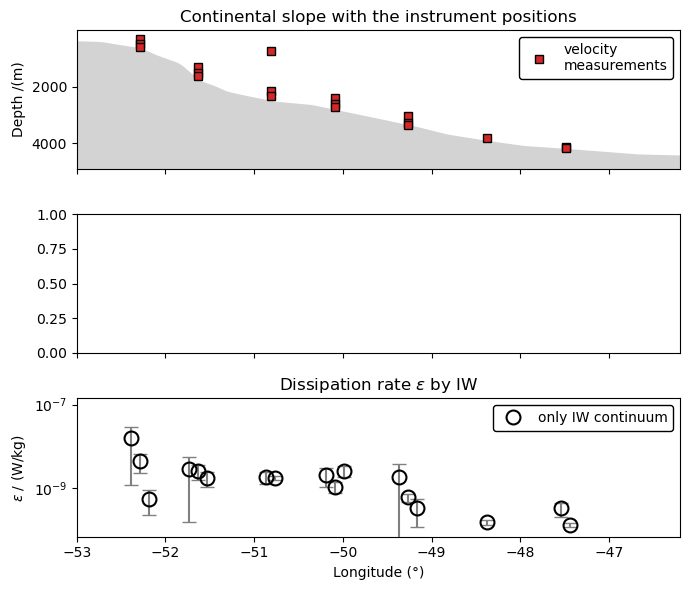

In [68]:
data = np.load("../../data/transect_bathymetry.npz") 
bat_depth = data["depth"]
bat_lon = data["lon"]

#find out how many points per location will be drawn
groups = energy_levels.groupby("lon")
fig,ax = plt.subplots(nrows = 3, sharex = True, figsize = (7,6))
for lon in set(energy_levels["lon"]):
    print(lon)
    group = groups.get_group(lon)
    group = group.sort_values("rounded_mab")
    nr_of_points = len(group.index)

    #to declutter the figure, points are shifted centered around the original x value. 
    # magnitude of the shift in units of the x coordinate
    xstep = 0.1
    xshift = np.arange(0,nr_of_points*xstep, xstep) 
    #distinction between 1 point (no shifts), odd and even points
    if nr_of_points%2 != 0 and len(xshift)!= 1:
        xshift = xshift[:-1]
    #centering    
    xshift = xshift - np.median(xshift)
       
    #if not group["baroclinic"].isnull().values.all():
    #    pass
        #ax[1].errorbar(group["lon"] + xshift, group["K_rho"], yerr = group["K_rho_error"], capsize = 5, fmt = "None", color = "xkcd:sky blue", zorder = 10)
        #ax[1].semilogy(group["lon"] + xshift, group["K_rho"], marker = ".", c = "tab:blue", ls = "None", ms = 15, zorder = 10)  
    #ax[1].errorbar(group["lon"] + xshift, group["K_rho_IW"], yerr = group["K_rho_IW_error"], capsize = 5, fmt = "None", color = "gray", zorder = 10)
    #ax[1].semilogy(group["lon"] + xshift, group["K_rho_IW"], marker = ".", ls = "None", c = "k", markeredgewidth=1.5, markerfacecolor = "none", ms = 20, zorder = 10)
    
    # label = "all IW, including tides"
    #ax[2].errorbar(group["lon"] + xshift, group["eps"], yerr = group["eps_error"], capsize = 5, fmt = "None", color = "xkcd:sky blue", zorder = 10)
    #ax[2].semilogy(group["lon"] + xshift, group["eps"], marker = ".", c = "tab:blue", ls = "None", ms = 15, zorder = 10)
    #label = "only IW continuum"
    ax[2].errorbar(group["lon"] + xshift, group["eps_IGW"], yerr = group["eps_IGW_error"], capsize = 5, fmt = "None", color = "gray", zorder = 10)
    ax[2].semilogy(group["lon"] + xshift, group["eps_IGW"], marker = ".", ls = "None", c = "k", markeredgewidth=1.5, markerfacecolor = "none", ms = 20, zorder = 10)


#ax[1].set_ylabel(r"$K_\rho$ / (m²s$^{-1}$)")

# only for the legend, shifted outside frame
#ax[1].semilogy(group["lon"] + xshift, 1e10*group["eps"], marker = ".", c = "tab:blue", ls = "None", ms = 15, label = "all IW,\nincluding semidiurnal tides")
#ax[1].semilogy(group["lon"] + xshift, 1e10*group["eps_IGW"], marker = ".", ls = "None", c = "k", markeredgewidth=1.5, markerfacecolor = "none", ms = 20, label = "only IW continuum")
#ax[1].set_ylim(3e-6,2e-1)
    
#ax[1].set_title(r"Diapycnal diffusivity $K_\rho$ by IW")
#import matplotlib
#locmaj = matplotlib.ticker.LogLocator(base=10,numticks=6) 
#ax[1].yaxis.set_major_locator(locmaj)
#locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=12)
#ax[1].yaxis.set_minor_locator(locmin)
#ax[1].yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax[2].set_xlabel("Longitude (°)")

#ax[1].legend(loc = "best", framealpha = 1, edgecolor = "k")#, facecolor = "lightgray")

ax[0].set_title(r"Continental slope with the instrument positions")
ax[0].invert_yaxis()
ax[0].fill_between(bat_lon,np.ones(len(bat_lon))*4900,bat_depth, color = "lightgrey")
ax[0].set_ylim(4900,10)
ax[0].set_ylabel("Depth /(m)")
for mooring in list_of_moorings:
    d = np.array(list(mooring.columns)[1:]).astype(float)
    ax[0].plot(mooring.location.lon*np.ones(len(d)),d,"s", color = "tab:red", markersize = 6, markeredgecolor = "k", zorder = 5)

ylims = ax[0].get_ylim()    
ax[0].plot(mooring.location.lon*np.ones(len(d)),-d,"s", label = "velocity\nmeasurements", color = "tab:red", markersize = 6, markeredgecolor = "k", zorder = 5)    
ax[0].set_ylim(ylims) 
ax[0].legend(loc = "best", framealpha = 1, edgecolor = "k")

ax[2].set_title(r"Dissipation rate $\varepsilon$ by IW")
ax[2].set_ylabel(r"$\varepsilon$ / (W/kg)")
ylims = ax[2].get_ylim()

# only for the legend, shifted outside frame
#ax[2].semilogy(group["lon"] + xshift, 1e10*group["eps"], marker = ".", c = "tab:blue", ls = "None", ms = 15, label = "all IW,\nincluding semidiurnal tides")
ax[2].semilogy(group["lon"] + xshift, 1e10*group["eps_IGW"], marker = ".", ls = "None", c = "k", markeredgewidth=1.5, markerfacecolor = "none", ms = 20, label = "only IW continuum")

ax[2].set_ylim(ylims[0]-2e-11,ylims[1]+1e-7)  
ax[2].legend(loc = "best", framealpha = 1, edgecolor = "k")

#ax[2].yaxis.set_major_locator(locmaj)
#locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=12)
#ax[2].yaxis.set_minor_locator(locmin)
#ax[2].yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

ax[0].set_xlim(-53,-46.2)

fig.tight_layout()    
#help.IO.save_as_pickle((f,a), name= "./data/K_rho_fig")
#fig.savefig("./figures/Krho_IW_poster", dpi = 300)

# Compare with Thorpe Estimates

In [69]:
def get_days_between(datePast, dateFuture):
    difference = dateFuture - datePast
    return difference.total_seconds() / datetime.timedelta(days=1).total_seconds()

In [70]:
import datetime
data = np.load("/home/ole/Desktop/Mooring_Analysis/energy_levels/data/Thorpe_result.npz", allow_pickle=True)
time_stamp = data["time_stamp"]
now = datetime.datetime.now()
print(f"Data saved {get_days_between(time_stamp, now):.1f} days ago")
mab = data["mab"]
eps_df = pd.read_pickle("./data/Thorpe_eps_df.pkl")
K_df = pd.read_pickle("./data/Thorpe_K_df.pkl")
T_df = pd.read_pickle("./data/Thorpe_T_df.pkl")

Data saved 111.5 days ago


FileNotFoundError: [Errno 2] No such file or directory: './data/Thorpe_eps_df.pkl'

In [ ]:
K_df

In [ ]:
print(f"Max = {K_df.max(axis = None):.1e}, Min = {K_df.min(axis = None):.1e}")

In [ ]:
BACKGROUND_DISSIPATION = 1e-10 #Hirano et al 2015
eps_df.fillna(value = BACKGROUND_DISSIPATION, inplace = True)
eps_df.where(cond = ~T_df.isna(), other = np.nan, inplace = True)

# add background diffusivity, but not where there is no temperature data
BACKGROUND_DIFFUSIVITY = 1e-5 #https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2017GL076269
K_df.fillna(value = BACKGROUND_DIFFUSIVITY, inplace = True)
K_df.where(cond = ~T_df.isna(), other = np.nan, inplace = True)
K_df.where(cond = K_df < 1, other = np.nan, inplace = True) # values too large are cut
K_df.head()

In [ ]:
print(f"Max = {K_df.max(axis = None):.1e}, Min = {K_df.min(axis = None):.1e}")

In [ ]:
lons = K_df.columns.to_numpy()
max_lon = max(lons)
min_lon = min(lons)
NUMBER_OF_BINS = 20
BIN_EDGES = np.linspace(min_lon-1e-3*min_lon, max_lon+1e-3*max_lon, NUMBER_OF_BINS + 1)

In [ ]:
import scipy.stats as ss

Order of magnitudes are averaged, instead of the value itself

In [ ]:
lons = K_df.columns.to_numpy()

rows = []
for index, row in eps_df.iterrows():
    values = row.to_numpy()
    bin_means= ss.binned_statistic(x = lons, values = values, statistic=np.nanmean, bins = BIN_EDGES)[0]
    new_eps = bin_means
    new_row = pd.DataFrame([new_eps], columns = BIN_EDGES[:-1])
    rows.append(new_row)
binned_eps_df = pd.concat(rows, sort = False).reset_index(drop = True)

rows = []
for index, row in K_df.iterrows():
    values = row.to_numpy()
    bin_means= ss.binned_statistic(x = lons, values = values, statistic=np.nanmean, bins = BIN_EDGES)[0]
    new_K = bin_means
    new_row = pd.DataFrame([new_K], columns = BIN_EDGES[:-1])
    rows.append(new_row)
binned_K_df = pd.concat(rows, sort = False).reset_index(drop = True)
    
#binned_K_df = binned_K_df.append(other = new_row, ignore_index=True)


rows = []
for index, row in T_df.iterrows():
    values = row.to_numpy()
    bin_means= ss.binned_statistic(x = lons, values = values, statistic=np.nanmean, bins = BIN_EDGES)[0]
    new_row = pd.DataFrame([bin_means], columns = BIN_EDGES[:-1])
    rows.append(new_row)

binned_T_df = pd.concat(rows, sort = False).reset_index(drop = True)
   

/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/li

/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/li

/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/li

/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/li

/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/li

/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/li

/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/li

/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/li

/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/li

/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/li

/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/li

/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/li

In [ ]:
binned_K_df

In [ ]:
import matplotlib.colors as mcolors

In [ ]:
f,a = plt.subplots(nrows = 1, figsize = (7,6), sharex = True)

norm = mcolors.LogNorm(vmin = 5e-5, vmax = 1e-1)
mpp = a.pcolormesh(
    binned_K_df.columns, 
    mab, 
    binned_K_df,
    norm = norm, 
    cmap = "hot_r",
)

a.set_facecolor('lightgrey')
cb = plt.colorbar(mpp, ax = a)
cb.set_label(r"Order of magnitude $K_\rho$")
a.set_xlabel("Longitude (°)")
a.set_title(r"Diapycnal diffusivity $K_\rho$")
a.contour(
    binned_T_df.columns, 
    mab, 
    binned_T_df,
    levels = [-0.7],
    colors = "k",
    linewidths = 3,
)
a.set_ylabel("Meters above bottom")
f.tight_layout()
#f.savefig("./Thorpe_Poster.png", dpi = 800)

In [ ]:
f,a = plt.subplots(nrows = 1, figsize = (8,6), sharex = True)

vmin = BACKGROUND_DIFFUSIVITY
vmax = 5e-2
norm = mcolors.LogNorm(vmin = vmin, vmax = vmax)
mpp = a.pcolormesh(
    binned_K_df.columns, 
    mab, 
    binned_K_df,
    norm = norm, 
    cmap = "hot_r",
)
cb = plt.colorbar(mpp, ax = a)
cb.set_label(r"$K_\rho$ / (m²s$^{-1}$)")

a.contour(
    binned_T_df.columns, 
    mab, 
    binned_T_df,
    levels = [-0.7],
    colors = "k",
    linewidths = 3,
)

from matplotlib.markers import MarkerStyle
a.scatter(
    energy_levels["lon"],
    energy_levels["mab"]+5,
    c=energy_levels["K_rho"],
    cmap = "hot_r",
    norm = norm,
    edgecolor="black",
    marker=MarkerStyle("o", fillstyle="left"),
    s = 500,
    zorder = 10)

a.scatter(
    energy_levels["lon"],
    energy_levels["mab"]+5,
    c=energy_levels["K_rho_IW"],
    cmap = "hot_r",
    norm = norm,
    edgecolor="black",
    marker=MarkerStyle("o", fillstyle="right"),
    s = 500,
    zorder = 10)

a.set_facecolor('lightgrey')
a.set_ylabel("Meters above bottom")
a.set_xlabel("Longitude (°)")
a.set_title(r"Diapycnal diffusivity $K_\rho$ across the slope")


#legend
a.scatter(
    energy_levels["lon"],
    energy_levels["mab"],
    color = "tab:gray",
    edgecolor="black",
    marker=MarkerStyle("o", fillstyle="left"),
    s = 400,
    zorder = -10,
    label = "wave-induced\ninclud. tides"
)

a.scatter(
    energy_levels["lon"],
    energy_levels["mab"],
    color = "tab:gray",
    edgecolor="black",
    marker=MarkerStyle("o", fillstyle="right"),
    s = 400,
    zorder = -10,
    label = "wave-induced\nexclud. tides"
)
a.legend(labelspacing =1.5)

a.annotate('extent of\nbottom current', xy=(-49.4, 195), xytext=(-48.2, 230),
            arrowprops=dict(facecolor='black', width = 2, shrink=0.05), ha = "center", color = "white", bbox=dict(facecolor='black', alpha = 0.8, edgecolor='black', boxstyle='round, pad = 0.5'))
  
    
f.tight_layout()
#f.savefig("./figures/Conclusion.png", dpi = 300)

In [ ]:
f,a = plt.subplots(nrows = 2, figsize = (8,6), sharex = True)

#-----------------------------------------------------------------------
#-----------------------------------------------------------------------
# Upper subfigure

vmin = BACKGROUND_DIFFUSIVITY
vmax = 5e-2
norm = mcolors.LogNorm(vmin = vmin, vmax = vmax)
mpp = a[0].pcolormesh(
    binned_K_df.columns, 
    mab, 
    binned_K_df,
    norm = norm, 
    cmap = "hot_r",
)
cb = plt.colorbar(mpp, ax = a[0])
cb.set_label(r"$K_\rho$ / (m²s$^{-1}$)")

a[0].contour(
    binned_T_df.columns, 
    mab, 
    binned_T_df,
    levels = [-0.7],
    colors = "k",
    linewidths = 3,
)


a[0].scatter(
    energy_levels["lon"],
    energy_levels["mab"]+5,
    c=energy_levels["K_rho_IW"],
    cmap = "hot_r",
    norm = norm,
    edgecolor="black",
    marker="o",
    s = 500,
    zorder = 10)

a[0].set_facecolor('lightgrey')
a[0].set_ylabel("Meters above bottom")
#a[0].set_xlabel("Longitude (°)")
a[0].set_title(r"Diapycnal diffusivity $K_\rho$ across the slope")



a[0].scatter(
    energy_levels["lon"],
    energy_levels["mab"],
    color = "tab:gray",
    edgecolor="black",
    marker="o",
    s = 300,
    zorder = -10,
    label = r"wave-induced $K_\rho$"+"\nexclud. tides"
)
a[0].legend(labelspacing =1.5)

a[0].annotate('extent of\nbottom current', xy=(-49.4, 195), xytext=(-48.2, 230),
            arrowprops=dict(facecolor='black', width = 2, shrink=0.05), ha = "center", color = "white", bbox=dict(facecolor='black', alpha = 0.8, edgecolor='black', boxstyle='round, pad = 0.5'))
  

#-----------------------------------------------------------------------
#-----------------------------------------------------------------------
# Lower subfigure

    
vmin = BACKGROUND_DISSIPATION
vmax = 1e-7
norm = mcolors.LogNorm(vmin = vmin, vmax = vmax)
mpp = a[1].pcolormesh(
    binned_eps_df.columns, 
    mab, 
    binned_eps_df,
    norm = norm, 
    cmap = "viridis_r",
)
cb = plt.colorbar(mpp, ax = a[1])
cb.set_label(r"$\varepsilon$ / (W kg$^{-1}$)")

a[1].contour(
    binned_T_df.columns, 
    mab, 
    binned_T_df,
    levels = [-0.7],
    colors = "k",
    linewidths = 3,
)


a[1].scatter(
    energy_levels["lon"],
    energy_levels["mab"]+5,
    c=energy_levels["eps_IW"],
    cmap = "viridis_r",
    norm = norm,
    edgecolor="black",
    marker="o",
    s = 500,
    zorder = 10)

a[1].set_facecolor('lightgrey')
a[1].set_ylabel("Meters above bottom")
a[1].set_xlabel("Longitude (°)")
a[1].set_title(r"Dissipation rate $\varepsilon$ across the slope")



a[1].scatter(
    energy_levels["lon"],
    energy_levels["mab"],
    color = "tab:gray",
    edgecolor="black",
    marker="o",
    s = 300,
    zorder = -10,
    label = r"wave-induced $\varepsilon$"+"\nexclud. tides"
)
a[1].legend(labelspacing =1.5)

a[1].annotate('extent of\nbottom current', xy=(-49.4, 195), xytext=(-48.2, 230),
            arrowprops=dict(facecolor='black', width = 2, shrink=0.05), ha = "center", color = "white", bbox=dict(facecolor='black', alpha = 0.8, edgecolor='black', boxstyle='round, pad = 0.5'))
  
    
#-----------------------------------------------------------------------
#-----------------------------------------------------------------------
# Save Result

f.tight_layout()
#f.savefig("./figures/Conclusion2.png", dpi = 300)

In [ ]:
f,a = plt.subplots(nrows = 2, figsize = (8,6), sharex = True)

#-----------------------------------------------------------------------
#-----------------------------------------------------------------------
# Upper subfigure

vmin = BACKGROUND_DIFFUSIVITY
vmax = 5e-2
norm = mcolors.LogNorm(vmin = vmin, vmax = vmax)
mpp = a[0].pcolormesh(
    binned_K_df.columns, 
    mab, 
    binned_K_df,
    norm = norm, 
    cmap = "hot_r",
)
cb = plt.colorbar(mpp, ax = a[0])
cb.set_label(r"$K_\rho$ / (m²s$^{-1}$)")

a[0].contour(
    binned_T_df.columns, 
    mab, 
    binned_T_df,
    levels = [-0.7],
    colors = "k",
    linewidths = 3,
)

a[0].scatter(
    energy_levels["lon"],
    energy_levels["mab"]+5,
    c=energy_levels["K_rho"],
    cmap = "hot_r",
    norm = norm,
    edgecolor="black",
    marker=MarkerStyle("o", fillstyle="left"),
    s = 500,
    zorder = 10)

a[0].scatter(
    energy_levels["lon"],
    energy_levels["mab"]+5,
    c=energy_levels["K_rho_IW"],
    cmap = "hot_r",
    norm = norm,
    edgecolor="black",
    marker=MarkerStyle("o", fillstyle="right"),
    s = 500,
    zorder = 10)


a[0].set_facecolor('lightgrey')
a[0].set_ylabel("Meters above bottom")
#a[0].set_xlabel("Longitude (°)")
a[0].set_title(r"Diapycnal diffusivity $K_\rho$ across the slope")

a[0].scatter(
    energy_levels["lon"],
    energy_levels["mab"],
    color = "tab:gray",
    edgecolor="black",
    marker=MarkerStyle("o", fillstyle="left"),
    s = 400,
    zorder = -10,
    label = r"wave-induced $K_\rho$"+"\ninclud. tides"
)

a[0].scatter(
    energy_levels["lon"],
    energy_levels["mab"],
    color = "tab:gray",
    edgecolor="black",
    marker=MarkerStyle("o", fillstyle="right"),
    s = 300,
    zorder = -10,
    label = r"wave-induced $K_\rho$"+"\nexclud. tides"
)


a[0].legend(labelspacing = 1.2, loc = "upper right")

a[0].annotate('extent of\nbottom current', xy=(-49.6, 160), xytext=(-48.2, 160),
            arrowprops=dict(facecolor='black', width = 2, shrink=0.05), ha = "center", color = "white", bbox=dict(facecolor='black', alpha = 0.8, edgecolor='black', boxstyle='round, pad = 0.5'))
  

#-----------------------------------------------------------------------
#-----------------------------------------------------------------------
# Lower subfigure

    
vmin = BACKGROUND_DISSIPATION
vmax = 1e-7
norm = mcolors.LogNorm(vmin = vmin, vmax = vmax)
mpp = a[1].pcolormesh(
    binned_eps_df.columns, 
    mab, 
    binned_eps_df,
    norm = norm, 
    cmap = "viridis_r",
)
cb = plt.colorbar(mpp, ax = a[1])
cb.set_label(r"$\varepsilon$ / (W kg$^{-1}$)")

a[1].contour(
    binned_T_df.columns, 
    mab, 
    binned_T_df,
    levels = [-0.7],
    colors = "k",
    linewidths = 3,
)


a[1].scatter(
    energy_levels["lon"],
    energy_levels["mab"]+5,
    c=energy_levels["eps"],
    cmap = "viridis_r",
    norm = norm,
    edgecolor="black",
    marker=MarkerStyle("o", fillstyle="left"),
    s = 500,
    zorder = 10
)

a[1].scatter(
    energy_levels["lon"],
    energy_levels["mab"]+5,
    c=energy_levels["eps_IW"],
    cmap = "viridis_r",
    norm = norm,
    edgecolor="black",
    marker=MarkerStyle("o", fillstyle="right"),
    s = 500,
    zorder = 10
)


a[1].set_facecolor('lightgrey')
a[1].set_ylabel("Meters above bottom")
a[1].set_xlabel("Longitude (°)")
a[1].set_title(r"Dissipation rate $\varepsilon$ across the slope")


a[1].scatter(
    energy_levels["lon"],
    energy_levels["mab"]+5,
    color = "tab:gray",
    edgecolor="black",
    marker=MarkerStyle("o", fillstyle="left"),
    s = 300,
    zorder = -10,    
    label = r"wave-induced $\varepsilon$"+"\ninclud. tides"
)

a[1].scatter(
    energy_levels["lon"],
    energy_levels["mab"]+5,
    color = "tab:gray",
    edgecolor="black",
    marker=MarkerStyle("o", fillstyle="right"),
    s = 300,
    zorder = -10,
    label = r"wave-induced $\varepsilon$"+"\nexclud. tides"
)


a[1].legend(labelspacing = 1.2, loc = "upper right")

a[1].annotate('extent of\nbottom current', xy=(-49.6, 160), xytext=(-48.2, 160),
            arrowprops=dict(facecolor='black', width = 2, shrink=0.05), ha = "center", color = "white", bbox=dict(facecolor='black', alpha = 0.8, edgecolor='black', boxstyle='round, pad = 0.5'))
  
    
#-----------------------------------------------------------------------
#-----------------------------------------------------------------------
# Save Result

f.tight_layout()
#f.savefig("./figures/Conclusion3.png", dpi = 300)

In [ ]:
f,ax = plt.subplots(nrows = 1, figsize = (8,4))

#-----------------------------------------------------------------------
#-----------------------------------------------------------------------
    
vmin = BACKGROUND_DISSIPATION
vmax = 1e-7
norm = mcolors.LogNorm(vmin = vmin, vmax = vmax)
mpp = ax.pcolormesh(
    binned_eps_df.columns, 
    mab, 
    binned_eps_df,
    norm = norm, 
    cmap = "viridis_r",
)
cb = plt.colorbar(mpp, ax = ax)
cb.set_label(r"$\varepsilon$ / (W kg$^{-1}$)")

ax.contour(
    binned_T_df.columns, 
    mab, 
    binned_T_df,
    levels = [-0.7],
    colors = "k",
    linewidths = 3,
)


ax.scatter(
    energy_levels["lon"],
    energy_levels["mab"]+5,
    c=energy_levels["eps"],
    cmap = "viridis_r",
    norm = norm,
    edgecolor="black",
    marker=MarkerStyle("o", fillstyle="left"),
    s = 500,
    zorder = 10
)

ax.scatter(
    energy_levels["lon"],
    energy_levels["mab"]+5,
    c=energy_levels["eps_IW"],
    cmap = "viridis_r",
    norm = norm,
    edgecolor="black",
    marker=MarkerStyle("o", fillstyle="right"),
    s = 500,
    zorder = 10
)


ax.set_facecolor('lightgrey')
ax.set_ylabel("Meters above bottom")
ax.set_xlabel("Longitude (°)")
ax.set_title(r"Dissipation rate $\varepsilon$ across the slope")


ax.scatter(
    energy_levels["lon"],
    energy_levels["mab"]+5,
    color = "tab:gray",
    edgecolor="black",
    marker=MarkerStyle("o", fillstyle="left"),
    s = 300,
    zorder = -10,    
    label = r"wave-induced $\varepsilon$"+"\ninclud. tides"
)

ax.scatter(
    energy_levels["lon"],
    energy_levels["mab"]+5,
    color = "tab:gray",
    edgecolor="black",
    marker=MarkerStyle("o", fillstyle="right"),
    s = 300,
    zorder = -10,
    label = r"wave-induced $\varepsilon$"+"\nexclud. tides"
)


ax.legend(labelspacing = 1.2, loc = "upper right")

ax.annotate('extent of\nbottom current', xy=(-49.6, 160), xytext=(-48.2, 160),
            arrowprops=dict(facecolor='black', width = 2, shrink=0.05), ha = "center", color = "white", bbox=dict(facecolor='black', alpha = 0.8, edgecolor='black', boxstyle='round, pad = 0.5'))
  
    
#-----------------------------------------------------------------------
#-----------------------------------------------------------------------
# Save Result

f.tight_layout()
#f.savefig("./figures/Conclusion3.png", dpi = 300)

In [ ]:
def fexp(f):
    return int(np.floor(np.log10(abs(f)))) if f != 0 else 0

def fman(f):
    return f/10**fexp(f)

In [ ]:
def generate_pattern(start, end):
    num_steps = (end - start) * 2  # Each step has a multiplier of 1 and 5
    return [multiplier * 10**(start + i // 2) for i, multiplier in enumerate([1, 5] * (num_steps + 1)) if start + i // 2 <= end]

# Example usage:
start_point = -10
end_point = -7

result_list = generate_pattern(start_point, end_point)
print(result_list)


In [ ]:
#mcolors.Colormap('viridis_r').resampled(ncolors)



In [ ]:
f,ax = plt.subplots(nrows = 1, figsize = (8,4))

#-----------------------------------------------------------------------
#-----------------------------------------------------------------------
start_point = -10
end_point = -7
bounds = generate_pattern(start_point, end_point)[:-1]
print(bounds)
ncolors = len(bounds) - 1
cmap = plt.cm.get_cmap('viridis_r', ncolors)
norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=ncolors)

#vmin = BACKGROUND_DISSIPATION
#vmax = 1e-7
#norm = mcolors.LogNorm(vmin = vmin, vmax = vmax)
mpp = ax.pcolormesh(
    binned_eps_df.columns, 
    mab, 
    binned_eps_df,
    norm = norm, 
    cmap = cmap,
)
cb = plt.colorbar(mpp, ax = ax)
cb.set_label(r"$\varepsilon$ / (W kg$^{-1}$)")
cb.ax.set_yticklabels([f'{fman(b):.1f}$\\times10^{{{fexp(b):.0f}}}$' for b in bounds])

ax.contour(
    binned_T_df.columns, 
    mab, 
    binned_T_df,
    levels = [-0.7],
    colors = "k",
    linewidths = 3,
)


ax.annotate('extent of\nbottom current', xy=(-49.6, 160), xytext=(-48.2, 160),
            arrowprops=dict(facecolor='black', width = 2, shrink=0.05), ha = "center", color = "white", bbox=dict(facecolor='black', alpha = 0.8, edgecolor='black', boxstyle='round, pad = 0.5'))
  
ax.set_facecolor('lightgrey')
ax.set_ylabel("Meters above bottom")
ax.set_xlabel("Longitude (°)")
ax.set_title(r"Dissipation rate $\varepsilon$ across the slope")    
#-----------------------------------------------------------------------
#-----------------------------------------------------------------------
# Save Result

f.tight_layout()
f.savefig("./figures/TotalDissipationRate.png", dpi = 300)

In [ ]:
f,ax = plt.subplots(nrows = 1, figsize = (8,4))

#-----------------------------------------------------------------------
#-----------------------------------------------------------------------
start_point = -10
end_point = -7
bounds = generate_pattern(start_point, end_point)[:-1]
print(bounds)
ncolors = len(bounds) - 1
cmap = plt.cm.get_cmap('viridis_r', ncolors)
norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=ncolors)

mpp = ax.pcolormesh(
    binned_eps_df.columns, 
    mab, 
    binned_eps_df,
    norm = norm, 
    cmap = cmap,
)
cb = plt.colorbar(mpp, ax = ax)
cb.set_label(r"$\varepsilon$ / (W kg$^{-1}$)")
cb.ax.set_yticklabels([f'{fman(b):.0f}$\\times10^{{{fexp(b):.0f}}}$' for b in bounds])

ax.contour(
    binned_T_df.columns, 
    mab, 
    binned_T_df,
    levels = [-0.7],
    colors = "k",
    linewidths = 3,
)

"""
ax.scatter(
    energy_levels["lon"],
    energy_levels["mab"]+5,
    c=energy_levels["eps"],
    cmap = "viridis_r",
    norm = norm,
    edgecolor="black",
    marker=MarkerStyle("o", fillstyle="left"),
    s = 500,
    zorder = 10
)
"""

ax.scatter(
    energy_levels["lon"],
    energy_levels["mab"]+5,
    c=energy_levels["eps_IW"],
    cmap = cmap,
    norm = norm,
    edgecolor="black",
    marker=MarkerStyle("o"),
    s = 500,
    zorder = 10
)


ax.set_facecolor('lightgrey')
ax.set_ylabel("Meters above bottom")
ax.set_xlabel("Longitude (°)")
ax.set_title(r"Dissipation rate $\varepsilon$ across the slope")

"""
ax.scatter(
    energy_levels["lon"],
    energy_levels["mab"]+5,
    color = "tab:gray",
    edgecolor="black",
    marker=MarkerStyle("o", fillstyle="left"),
    s = 300,
    zorder = -10,    
    label = r"wave-induced $\varepsilon$"+"\ninclud. tides"
)
"""

ax.scatter(
    energy_levels["lon"],
    energy_levels["mab"],
    color = "tab:gray",
    edgecolor="black",
    marker=MarkerStyle("o"),
    s = 300,
    zorder = -10,
    label = r"wave-induced $\varepsilon$"+"\nexclud. tides"
)


ax.legend(labelspacing = 1.2, loc = "upper right")

ax.annotate('extent of\nbottom current', xy=(-49.6, 160), xytext=(-48.2, 160),
            arrowprops=dict(facecolor='black', width = 2, shrink=0.05), ha = "center", color = "white", bbox=dict(facecolor='black', alpha = 0.8, edgecolor='black', boxstyle='round, pad = 0.5'))
  
    
#-----------------------------------------------------------------------
#-----------------------------------------------------------------------
# Save Result

f.tight_layout()
f.savefig("./figures/TotalWaveDissipation.png", dpi = 300)

In [ ]:
energy_levels.to_csv("wave_energy_result.csv")